### Cargar un modelo Word2Vec pre-entrenado para el español

ver: https://github.com/dccuchile/spanish-word-embeddings

In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_fbk_v1.csv"
df = pd.read_csv(dataset)



In [3]:
df["LargeText"] = df["LinkText"]+" "+df["Message"]

In [4]:
noticias = df.LargeText[df["tipo"]==1]

len(noticias)

104

In [5]:
import re
# Remove Emails
noticias = [re.sub(r'\S*@\S*\s?', '', sent) for sent in noticias]

# Remove new line characters
noticias = [re.sub(r'\s+', ' ', sent) for sent in noticias]

# Remove distracting single quotes
noticias= [re.sub("\'", "", sent) for sent in noticias]

# Remove links
noticias = [re.sub(r'\S*http\S*\s?', '', sent) for sent in noticias]
noticias = [re.sub(r'\S*https\S*\s?', '', sent) for sent in noticias]


In [6]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


In [7]:
documents=[]
for noticia in noticias:
    documents.append(spacy_tokenizer(noticia))

In [8]:
etm_documents=[]
for document in documents:
    etm_documents.append(" ".join(document))

In [9]:
from embedded_topic_model.utils import preprocessing
import json

# Preprocessing the dataset
diccionario, train_dataset,test_dataset, = preprocessing.create_etm_datasets(
    etm_documents, 
    min_df=0.01, 
    max_df=0.75, 
    train_size=0.85, 
)



In [10]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance
perp =[]
numk = range(1,10)
for k in numk:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=k,
        epochs=200,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))



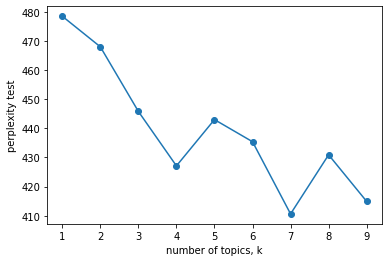

In [11]:
import matplotlib.pyplot as plt
plt.plot(numk, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [19]:
from embedded_topic_model.models.etm import ETM
etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=4,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

etm_instance.fit(train_dataset, test_dataset)

In [20]:
import numpy as np
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=4
nDoc = len(dist)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)
print(topics)

[['red', 'social', 'falso', 'noticia', 'desinformación', 'región', 'informar', 'canal', 'hora', 'facebook', 'circular', 'digital', 'importante', 'coronavirus', 'confirmar', 'rumor', 'desmentir', 'comuna', 'whatsapp', 'caso'], ['empty', 'fake', 'new', 'él', 'falso', 'decir', 'diputado', 'partido', 'paso', 'imagen', 'video', 'chile', 'político', 'enfoque', 'digital', 'tiempo', 'kast', 'infodemia', 'candidato', 'medio'], ['persona', 'él', 'programa', 'social', 'fondo', 'gobierno', 'calle', 'situación', 'chileno', 'piñera', 'año', 'vida', 'futuro', 'investigación', 'momento', 'desarrollo', 'familia', 'lugar', 'entregar', 'recibir'], ['información', 'falso', 'desinformación', 'maipú', 'libertad', 'acción', 'prensa', 'noticia', 'presentar', 'difundir', 'voz', 'leer', 'transparencia', 'expresión', 'opinión', 'legal', 'comunicación', 'fuente', 'mundial', 'público']]


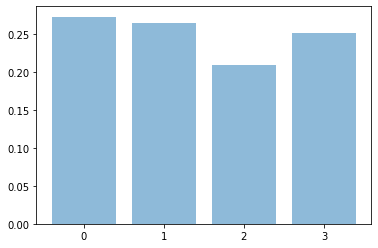

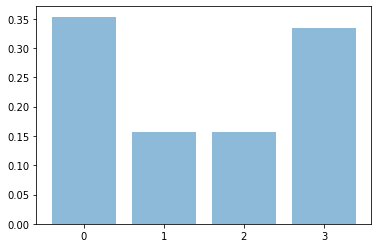

[0.04870179, 0.04182796, 0.041675404, 0.041339096, 0.022904187, 0.015507632, 0.014354168, 0.014332043, 0.013847661, 0.013463753, 0.0123126665, 0.0120946225, 0.010811447, 0.010193754, 0.00984332]


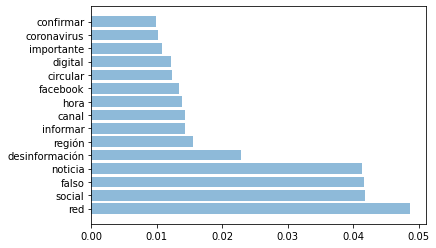

[0.06587739, 0.05014078, 0.041920327, 0.028656103, 0.02112918, 0.0124863135, 0.011134699, 0.010679473, 0.010014479, 0.009863573, 0.009114701, 0.0090634385, 0.009050085, 0.008745024, 0.008522908]


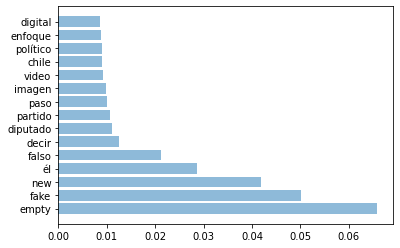

[0.03863551, 0.020746354, 0.015311603, 0.015010697, 0.014949965, 0.011449983, 0.011160131, 0.010525388, 0.009483664, 0.009374969, 0.009106693, 0.007939526, 0.00783265, 0.0077236174, 0.007381752]


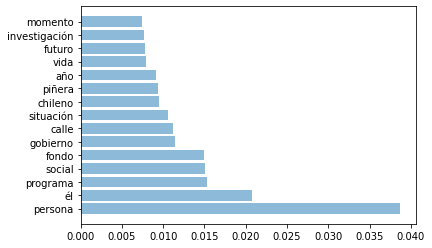

[0.07832186, 0.02776024, 0.024479419, 0.02290742, 0.022522356, 0.015257135, 0.014758816, 0.012669674, 0.01199667, 0.011466787, 0.011005565, 0.0094311815, 0.008983945, 0.008931378, 0.008569286]


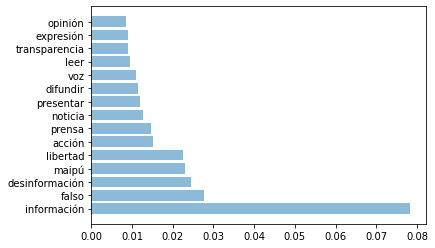

In [21]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



In [22]:
doc_l = np.zeros(len(train_dataset['counts']))
term_f= np.zeros(len(diccionario))
for i in range(0,len(train_dataset['counts'])):
        for j in range(0,len(train_dataset['counts'][i])):
                js = train_dataset['tokens'][i][j]
             
                term_f[js] = term_f[js] + train_dataset['counts'][i][j]
                doc_l[i] = doc_l[i]+ train_dataset['counts'][i][j]

In [23]:
import pyLDAvis
prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

In [25]:
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)
print(etm_instance._perplexity(test_dataset))

-0.0013377181740509207
0.93
397.0
